# Swissroads Project: 04 - Decision trees  

## General presentation
This is the first notebook of the Swissroad classification project. The aim of this project is to construct several classifiers to identify vehicles photographied in the streets around the Swiss School: EPFL. The project will be split into 9 jupyter notebook, each performing a specific task.
Our dataset comprises color photographies of 6 different types of vehicles: 
* Bikes
* Cars 
* Motorcycles
* Trucks 
* Vans 
* Others (for example, buses, scooters, etc.) 
Our data is already split into a train, validation and test set, with respectively: 280, 139 and 50 images of sizes 250x250. 
This is a relatively small dataset. When state of the art models trained for similar tasks on larger datasets are already documented and available, a beneficial option is to use one of these pre-trained model on our own dataset, either for classification purposes directly, or as a way of extracting features from the deep layers to inject these features in other machine learning models. This option is beneficial as it allows us to benefit from information obtained on a very large dataset and allows us to save time, as training complex convolutional networks is computationally expensive and can be very time consuming especially on a personal computer. 

For this project, we will use the Inception_v3 model available on the tensorflow hub to extract the 2048 most important features and use them in different classifiers: 
* A k-nearest neighbors classifiers
* A simple decision tree
* A logistic regression model
* Non linear classifiers such as Random Forest and SVMs 
* A dense network

Finally, we will also attempt to achieve the same level of accuracy by training our own convolutional network from scratch on our specific dataset.


## Aim of this notebook 

The goal of this jupyter notebook is to build a classifier to classify vehicle images from the swissroads dataset, using a simple decision tree. 

As a first step, we will build a decision tree with depths 3 on the high-level features extracted with the Inception_v3 convolutional network from the tensorflow hub, then we will compare the results with the ones obtained after reducing dimensions using a PCA. 

In [1]:
# loading libraries

import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os


In [2]:
# loading data
# Load data
with np.load('data/train.npz', allow_pickle=False) as npz_file:
    X_tr = npz_file['features']
    y_tr = npz_file['targets']
    names_tr = npz_file['names']
    
with np.load('data/valid.npz', allow_pickle=False) as npz_file:
    X_val = npz_file['features']
    y_val = npz_file['targets']
    names_val = npz_file['names']
    
with np.load('data/test.npz', allow_pickle=False) as npz_file:
    X_te = npz_file['features']
    y_te = npz_file['targets']
    names_te = npz_file['names']

Even though, decision trees don't need a lot of preprocessing compared to other methods, we still need to first transform the targets into numerical variables, as sklearn does not support non numeric data for multiclass classification problems. 

In [3]:
from sklearn.preprocessing import OrdinalEncoder

In [4]:
encoder = OrdinalEncoder()
enc_y_tr = encoder.fit_transform(y_tr.reshape(-1, 1))
enc_y_tr.shape

(280, 1)

First, le'ts fit a model without fine tuning. 

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

# Create decision tree
dt = DecisionTreeClassifier(
    criterion='gini', max_depth=3, random_state=0)


In [6]:
from sklearn import metrics 
# Fit decision tree
dt.fit(X_tr, enc_y_tr)

# Get score

print("Training accuracy: {}".format(round(metrics.accuracy_score(enc_y_tr, dt.predict(X_tr))*100, 2)))

Training accuracy: 78.57


In [7]:
# Get test score

enc_y_val = encoder.fit_transform(y_val.reshape(-1, 1))
print("Validation accuracy: {}".format(round(metrics.accuracy_score(enc_y_val, dt.predict(X_val))*100,2)))

Validation accuracy: 73.38


The accuracy of a naive decision tree of depth 3 aithout fine tuning is of 78% on the validation set. This tree is depicted iin the figure below:

In [8]:
from sklearn.tree import export_graphviz

# Export decision tree
dot_data = export_graphviz(
    dt, out_file=None,
    class_names=np.unique(y_tr),
    filled=True, rounded=True, proportion=True   
)

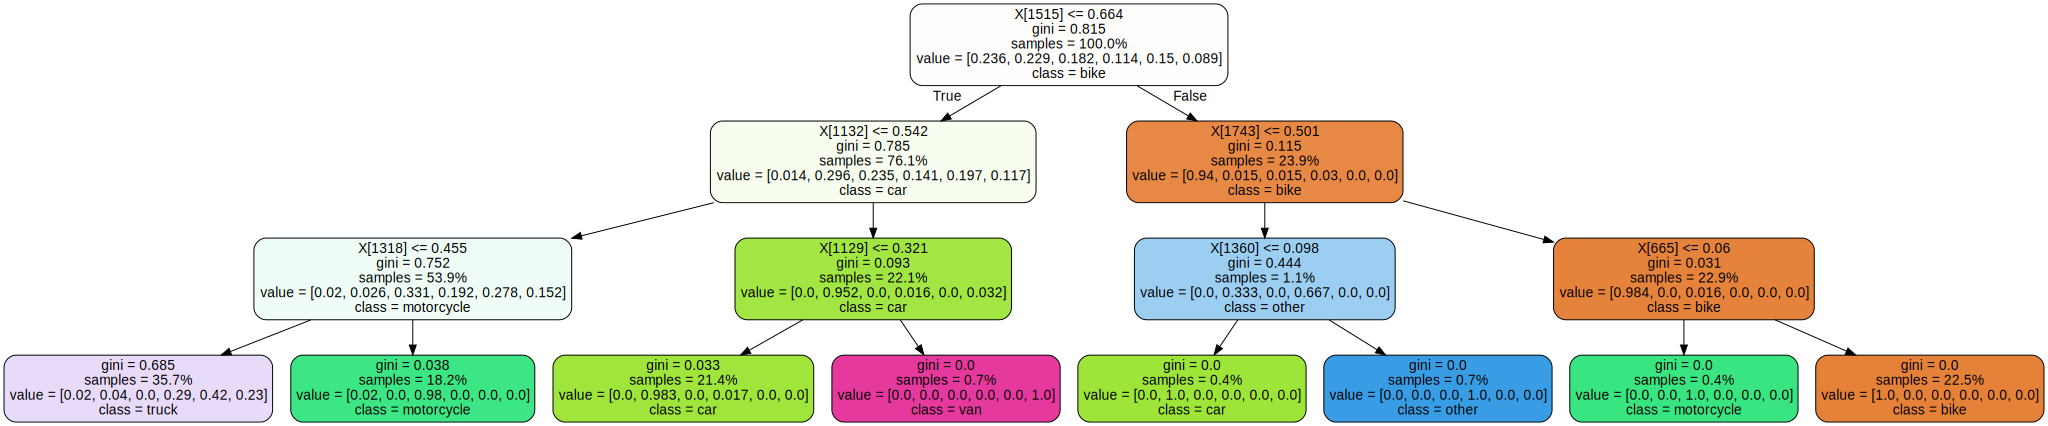

In [9]:
import graphviz

# Display decision tree
graphviz.Source(dot_data)

For image classification, a decision tree plot is not as nicely interpretable as for a dataset with multiple identifiable variables. Nevertheless, we can say that for example, an image with: 
* feature 1515 <= 0.664
* feature 1132 <= 0.542 
* feature 1318 > 0.455 

Would be classified as a motorcycle. 

While an image with:
* feature 1515 > 0.664
* feature 1743 > 0.501 
* feature 665 > 0.06 

Would be classified as a bike .

Let's try fine tuning the decision tree to increase the performance of our classifier. 
For this model, we will try to play around with: 
* the function to decide of the quality of a split
* the depth of the tree 
* the minimum mnumber of samples required to split an internal node

In [10]:
#Grid Search

from sklearn.model_selection import ParameterGrid

# Define a set of reasonable values
crit = ['gini', 'entropy'] 
depth = range(1,10)
min_split = [2, 5, 7, 9] # L1, L2 distances

pipe = Pipeline([
    ('tree', DecisionTreeClassifier(random_state = 0))
])

# Define a grid of values
grid = ParameterGrid({
    'tree__criterion': crit,
    'tree__max_depth': depth,
    'tree__min_samples_split': min_split
})

enc_y_val = encoder.fit_transform(y_val.reshape(-1, 1))
# Save accuracy on test set
test_scores = []

for params_dict in grid:
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a k-NN classifier
    pipe.fit(X_tr, enc_y_tr)
    
    # Save accuracy on training set
    params_dict['tr_accuracy'] = metrics.accuracy_score(enc_y_tr, pipe.predict(X_tr))

    # Save accuracy on validation set
    params_dict['val_accuracy'] = metrics.accuracy_score(enc_y_val, pipe.predict(X_val))


    # Save result
    test_scores.append(params_dict)

In [11]:
# Create DataFrame with test scores
scores_df = pd.DataFrame(test_scores)

best_params = scores_df.iloc[scores_df['val_accuracy'].idxmax(), :]

# Top five scores
scores_df.sort_values(by='val_accuracy', ascending=False).head(10)

,tr_accuracy,tree__criterion,tree__max_depth,tree__min_samples_split,val_accuracy
69,0.989286,entropy,9,5,0.841727
61,0.989286,entropy,7,5,0.841727
65,0.989286,entropy,8,5,0.841727
56,0.992857,entropy,6,2,0.834532
68,1.000000,entropy,9,2,0.827338
53,0.960714,entropy,5,5,0.827338
60,1.000000,entropy,7,2,0.827338
64,1.000000,entropy,8,2,0.827338
55,0.960714,entropy,5,9,0.827338
54,0.960714,entropy,5,7,0.827338


At the end of the grid search, we get an accuracy of 99 % on the training set and of 84% on the validation set. 
By fine tuning the decision tree, we improved the predictive performance of the classifier. 

We now fit the classifier with the best parameters a final time on the training and validation sets concatenated and use the resulting model to predict the classes on the test set: 

In [12]:
tree_final = DecisionTreeClassifier(criterion = best_params['tree__criterion'], 
                                    max_depth = best_params['tree__max_depth'], 
                                    min_samples_split = best_params['tree__min_samples_split'], random_state = 0)

tree_final.fit(np.vstack((X_tr, X_val)), np.concatenate((enc_y_tr, enc_y_val)))
enc_y_te = encoder.fit_transform(y_te.reshape(-1, 1))
accuracy = metrics.accuracy_score(enc_y_te, tree_final.predict(X_te))
print('Accuracy on the test set after fine tuning: {:.3f}'.format(accuracy))

Accuracy on the test set after fine tuning: 0.860


The final accuracy on the test set is 86%. The resulting tree is displayed below.  

In [13]:
# Export decision tree
tuned_tree = export_graphviz(
    tree_final, out_file=None,
    class_names=np.unique(y_tr),
    filled=True, rounded=True, proportion=True   
)

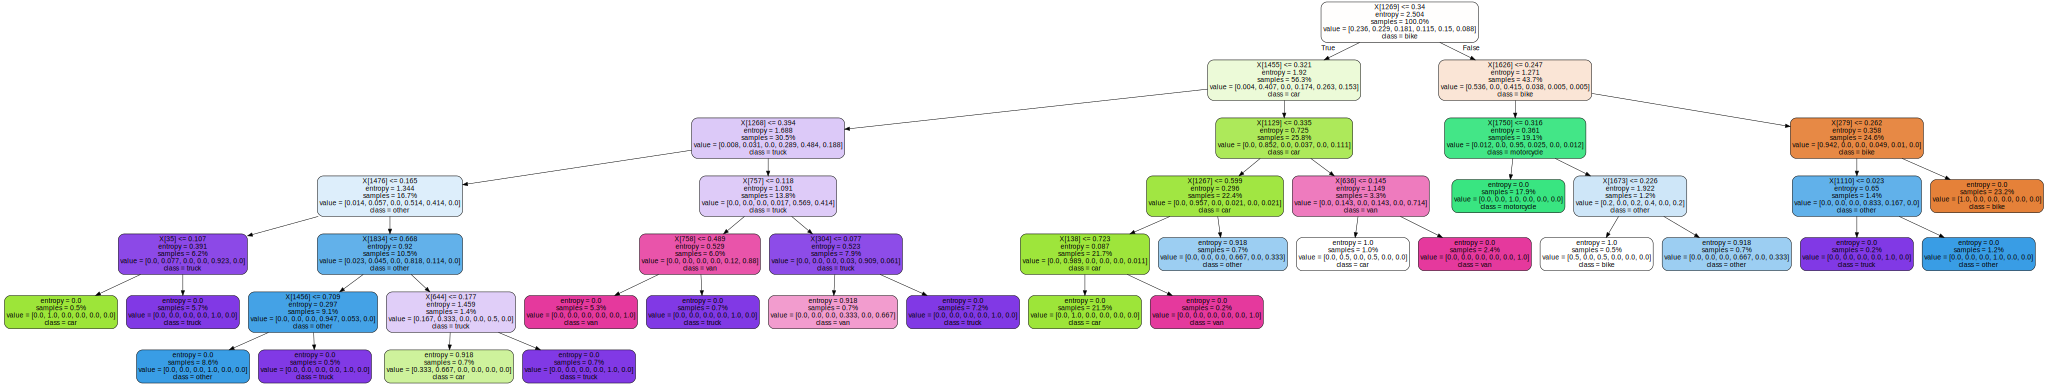

In [14]:
# Display decision tree
graphviz.Source(tuned_tree)

## Performing PCA before building the decision tree 

In this next step, we will first perfom a PCA in order to reduce the dimensionality of the dataset before constructing our decision tree. 
As established in the second jupyter notebook, the optimal number of dimensions to represent our high level features is 10. 


In [15]:
#using PCA to reduce dimensions before the applying decision tree 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [16]:
# Create Standard scaler
scaler = StandardScaler()

# Rescale data
X_tr_rescaled = scaler.fit_transform(X_tr)
X_val_rescaled = scaler.fit_transform(X_val)
X_te_rescaled = scaler.fit_transform(X_te)

# Create PCA transformer
pca = PCA(n_components=10)


# Apply PCA to rescaled data
#pca.fit(X_rescaled)
pca.fit(X_tr_rescaled)

pca_tr = pca.transform(X_tr_rescaled)
pca_val = pca.transform(X_val_rescaled)
pca_te = pca.transform(X_te_rescaled)


In [17]:
# Define a set of reasonable values
crit = ['gini', 'entropy'] # 1, 2, 3, .., 20
depth = range(1,10)
min_split = [2, 5, 7, 9] # L1, L2 distances

pipe = Pipeline([
    ('tree', DecisionTreeClassifier(random_state=0))
])

# Define a grid of values
grid = ParameterGrid({
    'tree__criterion': crit,
    'tree__max_depth': depth,
    'tree__min_samples_split': min_split
})

test_scores = []

for params_dict in grid:
    # Set parameters
    pipe.set_params(**params_dict)

    # Fit a k-NN classifier
    pipe.fit(pca_tr, enc_y_tr)

    # Save accuracy on test set
    params_dict['accuracy'] = metrics.accuracy_score(enc_y_val, pipe.predict(pca_val))

    # Save result
    test_scores.append(params_dict)

In [18]:
# Create DataFrame with test scores
scores_df = pd.DataFrame(test_scores)

best_params = scores_df.iloc[scores_df['accuracy'].idxmax(), :]

# Top five scores
scores_df.sort_values(by='accuracy', ascending=False).head(10)

,accuracy,tree__criterion,tree__max_depth,tree__min_samples_split
32,0.877698,gini,9,2
21,0.870504,gini,6,5
34,0.870504,gini,9,7
33,0.870504,gini,9,5
31,0.870504,gini,8,9
30,0.870504,gini,8,7
29,0.870504,gini,8,5
27,0.870504,gini,7,9
26,0.870504,gini,7,7
25,0.870504,gini,7,5


In [19]:
tree_final_pca = DecisionTreeClassifier(criterion = best_params['tree__criterion'], 
                                    max_depth = best_params['tree__max_depth'], 
                                    min_samples_split = best_params['tree__min_samples_split'] , random_state=0)

tree_final_pca.fit(np.vstack((pca_tr, pca_val)), np.concatenate((enc_y_tr, enc_y_val)))
accuracy_pca = metrics.accuracy_score(enc_y_te, tree_final_pca.predict(pca_te))
print('Accuracy after fine tuning: {:.3f}'.format(accuracy_pca))

Accuracy after fine tuning: 0.900


In [20]:
# Export decision tree
tuned_tree_pca = export_graphviz(
    tree_final_pca, out_file=None,
    class_names=np.unique(y_tr),
    filled=True, rounded=True, proportion=True   
)

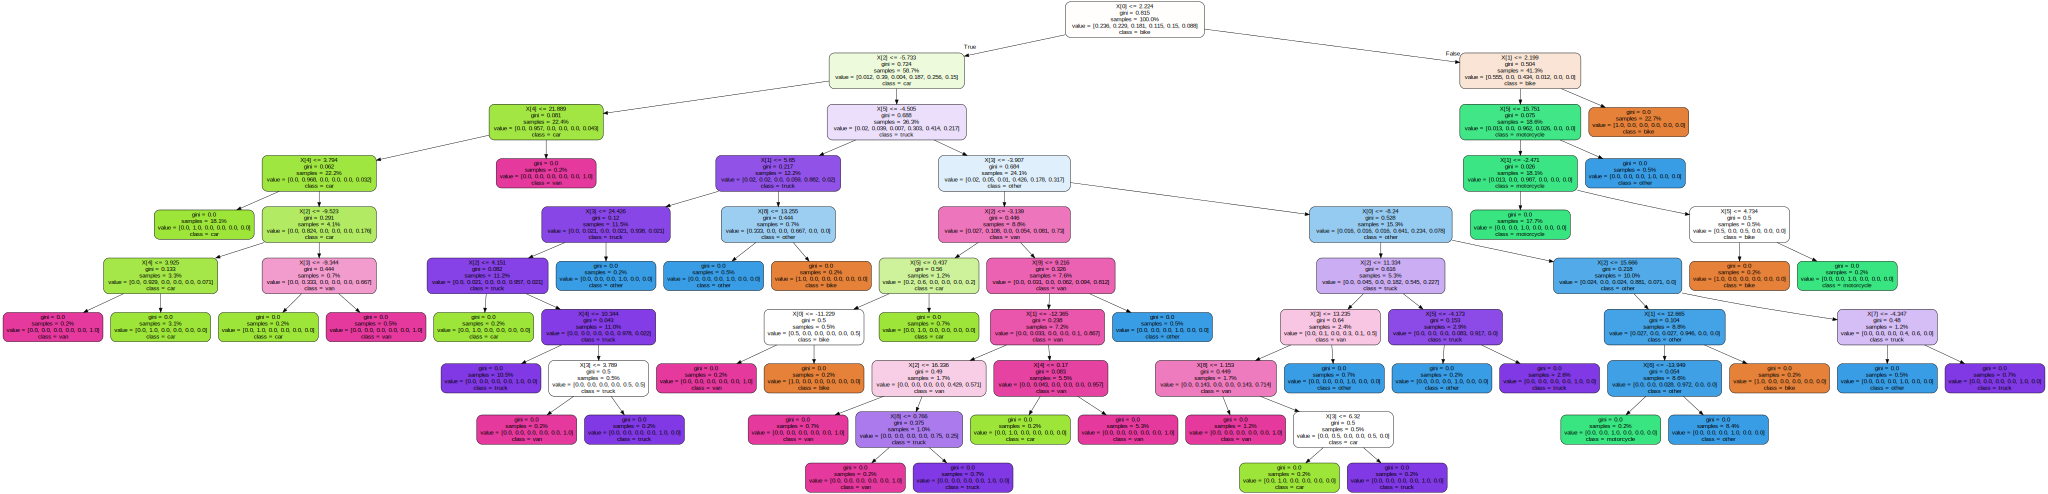

In [21]:
# Display decision tree
graphviz.Source(tuned_tree_pca)

The resulting tree is a bit complex, but managed to improve the predictive performance of the classifier to 90% on the test set. This is probably due to the ability of this classifier to discriminate between class of vehicles with similar features, such as car and van, or other and the other classes. 

Finally, we save these results to compare all methods. 

In [22]:
np.savez('results/02_tree.npz', test_accuracy=accuracy)
np.savez('results/03_tree-pca.npz', test_accuracy=accuracy_pca)